In [ ]:
%pip install pandas
%pip install matplotlib
%pip install nltk
%pip install scikit-learn


In [1]:
import pandas as pd 
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk

In [11]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('all')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\himan\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\himan\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to
[nltk_data]    |     C:\Users\himan\AppData\Roaming\nltk_data...
[nltk_data]    |   Unzipping corpora\abc.zip.
[nltk_data]    | Downloading package alpino to
[nltk_data]    |     C:\Users\himan\AppData\Roaming\nltk_data...
[nltk_data]    |   Unzipping corpora\alpino.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger to
[nltk_data]    |     C:\Users\himan\AppData\Roaming\nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger is already up-
[nltk_data]    |       to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger_eng to
[nltk_dat

True

In [20]:
df_fake = pd.read_csv(r'C:\Users\himan\Downloads\Learning\Projects\Fake News Detection\data\Fake.csv')
df_true = pd.read_csv(r'C:\Users\himan\Downloads\Learning\Projects\Fake News Detection\data\True.csv')

#Add labels to the dataframes
df_fake['fake'] = 1 # 1 for Fake
df_true['real'] = 0 # 0 for True

#Concatenate the dataframes
df = pd.concat([df_fake, df_true], ignore_index=True)
# Shuffle the dataframe
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

#combine the title and text columns
df['combined_text'] = df['title'].fillna('') + ' ' + df['text'].fillna('')

#Remove null or Empty values
df = df[df['combined_text'].str.strip() != '']

#Converting the text to lowercase
df['combined_text'] = df['combined_text'].str.lower()

#remove punctuation
df['combined_text'] = df['combined_text'].str.replace(r'[^\w\s]', '', regex=True)

#remove stopwords
#nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
df['combined_text'] = df['combined_text'].apply(lambda x: ' '.join(word for word in x.split() if word not in stop_words))

#Tokenization, Stemming, and removing non-alphabetic tokens
#nltk.download('punkt')
stemmer = PorterStemmer()

def preprocess(text):
	tokens = word_tokenize(text)
	stemmed_tokens = [stemmer.stem(token) for token in tokens if token.isalpha()]
	return ' '.join(stemmed_tokens)

df['combined_text'] = df['combined_text'].apply(preprocess)

#Apply TF-IDF Vectorization
tfidf = TfidfVectorizer(max_features=5000)
X = tfidf.fit_transform(df['combined_text']).toarray()
y = df['real'].values



In [21]:
null_values = df.isnull().sum().sum()
print(null_values)
df.dropna(inplace=True)
null_values_after = df.isnull().sum().sum()
print(null_values_after)

44898
0


In [22]:
#Counting real ad fake news
print(df['real'].value_counts())

Series([], Name: count, dtype: int64)


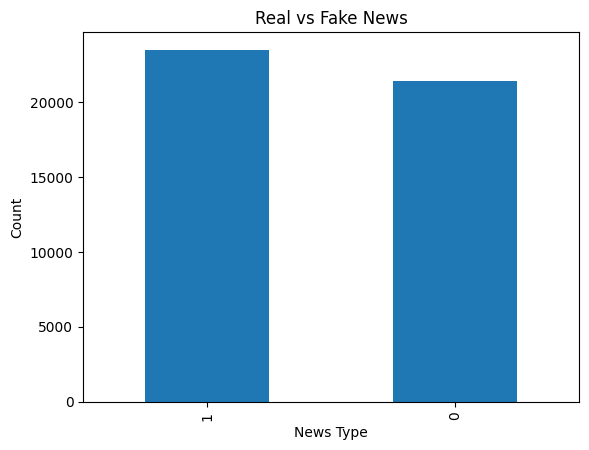

In [15]:
#Generating a bar plot for real and fake news
df['real'].value_counts().plot(kind='bar')
plt.title('Real vs Fake News')
plt.xlabel('News Type') 
plt.ylabel('Count')
plt.show()

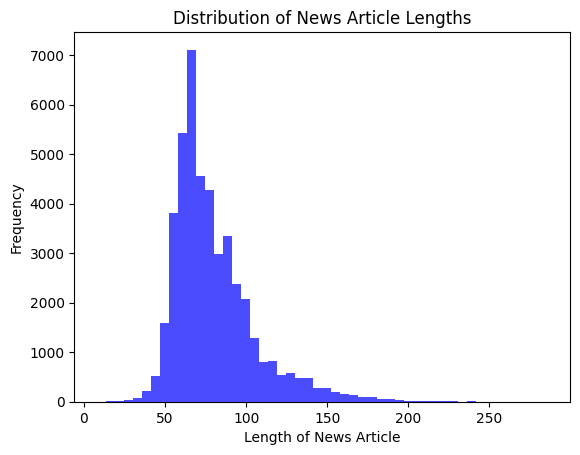

In [25]:
# Histogram of the length of news articles
# Compute lengths safely, even if df is empty
if 'title' in df.columns:
	df['text_length'] = df['title'].astype(str).str.len()

# Use df if it has data; otherwise fall back to raw datasets
if 'text_length' in df.columns and not df.empty:
	lengths = df['text_length'].astype('int64')
else:
	sources = []
	if 'df_fake' in globals():
		sources.append(df_fake['title'])
	if 'df_true' in globals():
		sources.append(df_true['title'])
	if sources:
		lengths = pd.concat(sources, ignore_index=True).dropna().astype(str).str.len()
	else:
		lengths = pd.Series([], dtype='int64')

plt.hist(lengths, bins=50, color='blue', alpha=0.7)
plt.title('Distribution of News Article Lengths')
plt.xlabel('Length of News Article')
plt.ylabel('Frequency')
plt.show()

## Observation - 1
It is seen that there are 5 columns and 23,196 entries in the dataset. There are 17,371 real news and 5495 fake news. The length of the most of the news title are in the range of 50-100 characters. 

### Preprocessing 

In [26]:
#Removing null or empty values
df = df.dropna(subset=['title', 'text'])

To do the phases above preprocessing before moving ahead

In [34]:
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split

# Create the target variable 'y'
# 'fake' column is 1 for fake, NaN for true. 'real' is 0 for true, NaN for fake.
# We can fill NaN in 'fake' with values from 'real' (which would be 0)
df['label'] = df['fake'].fillna(df['real'])
y = df['label'].astype(int)

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train models
lr_model = LogisticRegression()
lr_model.fit(X_train, y_train)

nb_model = MultinomialNB()
nb_model.fit(X_train, y_train)



,alpha,1.0
,force_alpha,True
,fit_prior,True
,class_prior,None


In [35]:
from sklearn.metrics import classification_report, confusion_matrix

# Logistic Regression Evaluation
y_pred_lr = lr_model.predict(X_test)
print("Logistic Regression Report:")
print(classification_report(y_test, y_pred_lr))

# Naive Bayes Evaluation
y_pred_nb = nb_model.predict(X_test)
print("Naive Bayes Report:")
print(classification_report(y_test, y_pred_nb))


Logistic Regression Report:
              precision    recall  f1-score   support

           0       0.98      0.99      0.99      4270
           1       0.99      0.98      0.99      4710

    accuracy                           0.99      8980
   macro avg       0.99      0.99      0.99      8980
weighted avg       0.99      0.99      0.99      8980

Naive Bayes Report:
              precision    recall  f1-score   support

           0       0.92      0.92      0.92      4270
           1       0.93      0.93      0.93      4710

    accuracy                           0.93      8980
   macro avg       0.93      0.93      0.93      8980
weighted avg       0.93      0.93      0.93      8980



Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.0.1 -> 25.2
[notice] To update, run: C:\Users\himan\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


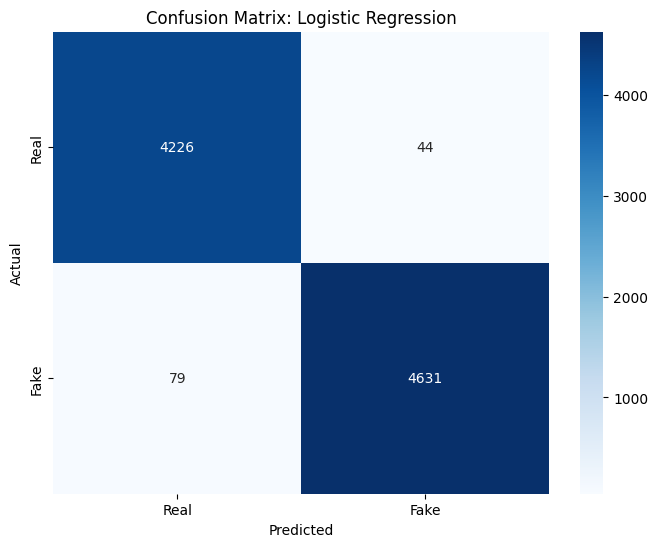

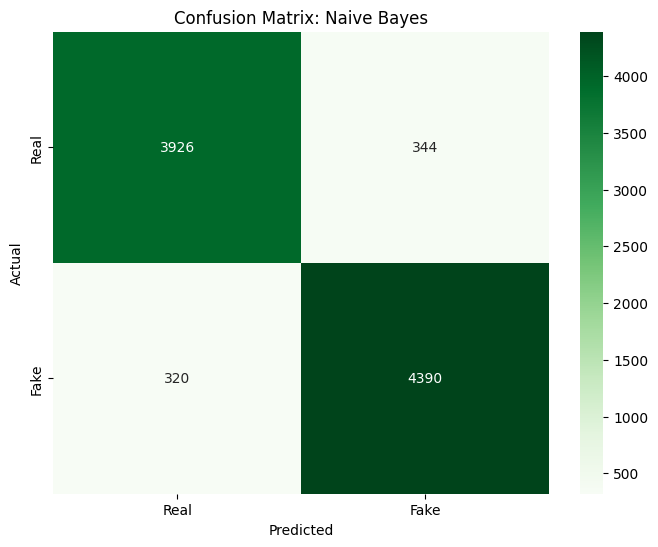

In [41]:
%pip install seaborn
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# --- Logistic Regression Confusion Matrix ---
cm_lr = confusion_matrix(y_test, y_pred_lr)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_lr, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Real', 'Fake'], yticklabels=['Real', 'Fake'])
plt.title('Confusion Matrix: Logistic Regression')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

# --- Naive Bayes Confusion Matrix ---
cm_nb = confusion_matrix(y_test, y_pred_nb)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_nb, annot=True, fmt='d', cmap='Greens',
            xticklabels=['Real', 'Fake'], yticklabels=['Real', 'Fake'])
plt.title('Confusion Matrix: Naive Bayes')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

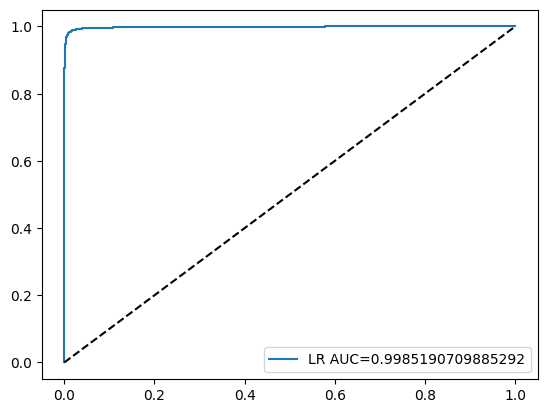

In [42]:
from sklearn.metrics import roc_curve, auc

y_pred_proba = lr_model.predict_proba(X_test)[::,1]
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
auc_score = auc(fpr, tpr)

plt.plot(fpr, tpr, label="LR AUC="+str(auc_score))
plt.plot([0,1],[0,1],'k--')
plt.legend()
plt.show()


In [48]:
import pickle
import os

# Define the directory path
model_dir = r"C:\Users\himan\Downloads\Learning\Projects\Fake News Detection\model"
os.makedirs(model_dir, exist_ok=True)

#import pickle

# Save Logistic Regression model
with open(os.path.join(model_dir, "lr_model.pkl"), "wb") as f:
    pickle.dump(lr_model, f)

# Save Naive Bayes model
with open(os.path.join(model_dir, "naive_bayes_model.pkl"), "wb") as f:
    pickle.dump(nb_model, f)

# Save TF-IDF vectorizer
with open(os.path.join(model_dir, "tfidf_vectorizer.pkl"), "wb") as f:
    pickle.dump(tfidf, f)

